# **Product Recommendation System : BigBasket Products Datasets**
- Nama: Fiyanda Ma'muri
- Email: fiyandamamuri@gmail.com
- ID Dicoding: fiyandamamuri


Dataset: https://www.kaggle.com/datasets/surajjha101/bigbasket-entire-product-list-28k-datapoints

## Project Overview

Notebook ini berisi implementasi sistem rekomendasi produk menggunakan dataset dari BigBasket. Tujuan utama proyek ini adalah membangun sistem rekomendasi:
- **Content-Based Filtering (CBF)**: merekomendasikan produk berdasarkan kemiripan atribut produk.

Sistem ini dirancang untuk membantu pengguna menemukan produk relevan dari ribuan item dalam katalog BigBasket.

## Business Understanding

BigBasket adalah platform e-commerce berbasis grosir dan ritel yang menjual beragam produk rumah tangga, makanan, dan kebutuhan harian. Dengan ribuan produk tersedia, pengguna dapat mengalami kebingungan dalam memilih.

**Tujuan bisnis** dari proyek ini adalah:
- Meningkatkan kenyamanan pengguna dalam menemukan produk.
- Meningkatkan konversi dan retensi pelanggan melalui rekomendasi yang relevan.
- Mengurangi waktu eksplorasi dengan menyarankan produk yang sesuai preferensi atau kebiasaan belanja pengguna.

## Data Understanding

Dataset yang digunakan berasal dari situs [Kaggle](https://www.kaggle.com/datasets/surajjha101/bigbasket-entire-product-list-28k-datapoints) dan berisi daftar lebih dari 28.000 produk yang dijual di platform e-commerce BigBasket. Dataset ini memiliki **10 atribut utama** yang masing-masing memberikan informasi penting mengenai setiap produk. Berikut ini adalah penjelasan masing-masing atribut:

| Nama Kolom      | Deskripsi                                                                 |
|------------------|--------------------------------------------------------------------------|
| `index`          | Nomor indeks baris pada dataset, hanya sebagai penanda urutan data.      |
| `product`        | Nama atau judul dari produk sebagaimana tercantum di situs BigBasket.     |
| `category`       | Kategori utama produk, seperti "Beauty & Hygiene", "Foodgrains", dll.     |
| `sub_category`   | Sub-kategori dari produk yang lebih spesifik dari kategori utama.         |
| `brand`          | Merek atau nama brand dari produk, seperti "Fresho", "bb Royal", dll.     |
| `sale_price`     | Harga jual produk di situs BigBasket (harga setelah diskon).              |
| `market_price`   | Harga pasar normal produk sebelum diskon.                                 |
| `type`           | Jenis atau bentuk produk, seperti "Oil", "Serum", "Tablet", dll.          |
| `rating`         | Nilai rating dari pengguna, dalam skala 1 sampai 5.                       |
| `description`    | Deskripsi lengkap produk yang menjelaskan manfaat dan informasi lainnya.  |

Dataset ini memiliki banyak nilai kosong pada kolom `rating` dan `description`, serta mengandung data multikategori yang dipisahkan oleh karakter seperti `&`, `,`, atau baris baru. Oleh karena itu, diperlukan beberapa tahapan pembersihan dan transformasi data sebelum digunakan dalam sistem rekomendasi. Namun karena saya akan menerapkan sistem rekomendasi dengan Content-Based Filtering, maka fitur yang dipakai merupakan fitur yang berbasis konten yang akan di jelaskan di bagian Data Preparation.

### Import Library

In [1]:
!pip install numpy==1.24.4
!pip install scikit-surprise --no-binary scikit-surprise

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2469553 sha256=4de38d255fad6a592f6cbb6e5b113fa3e4d41eda95c2953f3fdbd6a951b35fdb
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random

Mengimpor berbagai library yang dibutuhkan untuk analisis data, visualisasi, pemrosesan teks, dan pembangunan sistem rekomendasi.
- pandas, numpy: untuk manipulasi dan analisis data
- matplotlib, seaborn: untuk visualisasi eksploratif
- sklearn: untuk ekstraksi fitur, evaluasi, dan pemodelan konten
- surprise: untuk implementasi algoritma Collaborative Filtering berbasis matrix factorization (SVD)
- re: untuk pemrosesan teks dasar
- random: untuk pemilihan acak

Instalasi tambahan dilakukan untuk versi spesifik numpy dan scikit-surprise.



### Data Loading

In [3]:
df = pd.read_csv('BigBasket Products.csv')

df.head()

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


Memuat dataset BigBasket Products dari file CSV ke dalam DataFrame df untuk analisis lebih lanjut. Kemudian menampilkan 5 baris pertama sebagai gambaran awal struktur dan isi data.

### Exploratory Data Analysis (EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27555 entries, 0 to 27554
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         27555 non-null  int64  
 1   product       27554 non-null  object 
 2   category      27555 non-null  object 
 3   sub_category  27555 non-null  object 
 4   brand         27554 non-null  object 
 5   sale_price    27555 non-null  float64
 6   market_price  27555 non-null  float64
 7   type          27555 non-null  object 
 8   rating        18929 non-null  float64
 9   description   27440 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 2.1+ MB


Menampilkan informasi umum mengenai struktur dataset, termasuk jumlah baris, jumlah kolom, tipe data tiap kolom, serta jumlah nilai non-null. Dari output ini, terlihat bahwa terdapat nilai hilang khususnya pada kolom product, brand, rating, dan description.

In [5]:
df.describe()

,index,sale_price,market_price,rating
count,27555.00000,27555.000000,27555.000000,18929.000000
mean,13778.00000,322.514808,382.056664,3.943410
std,7954.58767,486.263116,581.730717,0.739063
min,1.00000,2.450000,3.000000,1.000000
25%,6889.50000,95.000000,100.000000,3.700000
50%,13778.00000,190.000000,220.000000,4.100000
75%,20666.50000,359.000000,425.000000,4.300000
max,27555.00000,12500.000000,12500.000000,5.000000


Menampilkan statistik deskriptif untuk kolom numerik dalam dataset.
Beberapa insight awal:

- Harga jual (sale_price) dan harga pasar (market_price) memiliki rentang yang cukup besar, menunjukkan variasi produk.

- Rata-rata rating pengguna adalah sekitar 3.94 dengan nilai maksimum 5 dan minimum 1, mengindikasikan adanya distribusi opini yang cukup lebar dari pengguna.

In [6]:
print("Missing values:")
df.isnull().sum()

Missing values:


,0
index,0
product,1
category,0
sub_category,0
brand,1
sale_price,0
market_price,0
type,0
rating,8626
description,115


Melakukan pengecekan nilai kosong (missing values) pada setiap kolom.
Hasilnya menunjukkan bahwa:

- Kolom rating memiliki jumlah nilai kosong paling banyak (8.626 baris), yang perlu ditangani karena digunakan untuk sistem rekomendasi.

- Kolom description juga memiliki missing values (115 baris), namun kemungkinan tidak krusial untuk model ini.

- Kolom product dan brand masing-masing hanya memiliki 1 nilai kosong.



In [7]:
print("Duplicates:")
df.duplicated().sum()

Duplicates:


0

Memeriksa apakah terdapat baris data yang duplikat dalam dataset.
Hasil menunjukkan bahwa tidak ada data duplikat, sehingga tidak diperlukan tindakan pembersihan untuk kasus ini.

In [8]:
#  Jumlah Nilai Unik per Kolom
print("Jumlah nilai unik tiap kolom:")
for col in ['product', 'category', 'sub_category', 'brand', 'rating']:
    print(f"- {col}: {df[col].nunique()}")

Jumlah nilai unik tiap kolom:
- product: 23540
- category: 11
- sub_category: 90
- brand: 2313
- rating: 40


Kode ini digunakan untuk menghitung jumlah nilai unik (distinct values) dari setiap kolom yang relevan dalam dataset, yaitu: product, category, sub_category, brand, dan rating.

Hasil yang diperoleh:
- product: 23.540 produk unik tercatat di dataset.
- category: 11 kategori utama.
- sub_category: 90 sub-kategori produk yang lebih spesifik.
- brand: 2.313 merek produk yang berbeda.
- rating: 40 nilai rating unik yang digunakan (kemungkinan dalam bentuk skala desimal atau integer bervariasi).

> Banyaknya produk dan brand menunjukkan keragaman konten produk yang sangat tinggi, cocok untuk digunakan dalam sistem rekomendasi berbasis konten (CBF).

> Rating yang beragam memberi potensi untuk analisis kualitas dan preferensi produk.

> Distribusi kategori dan sub-kategori dapat digunakan untuk mengelompokkan produk yang serupa.

<ipython-input-9-1706537353>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='category', data=df, order=df['category'].value_counts().index, palette='coolwarm')


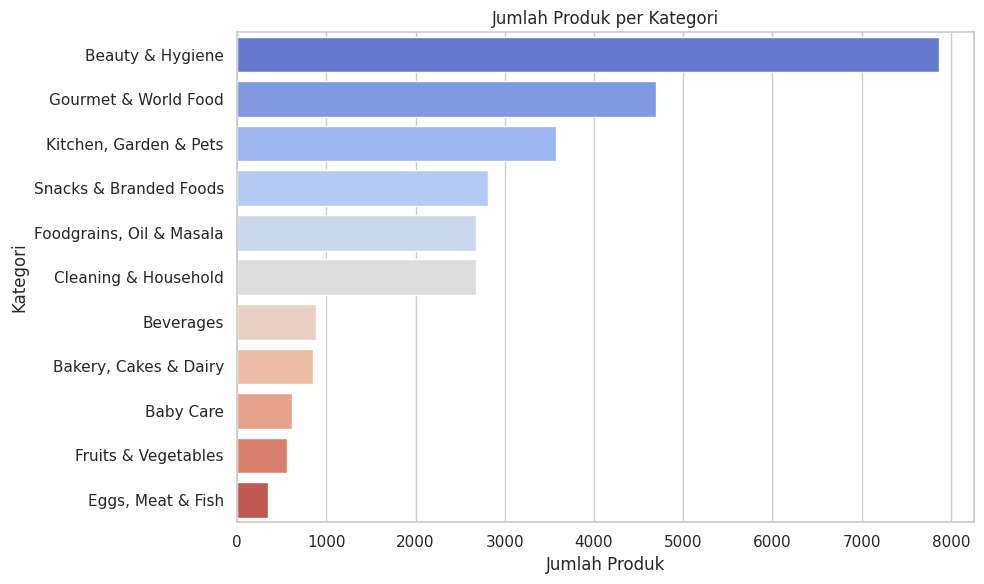

In [9]:
# Jumlah Item per Kategori
plt.figure(figsize=(10, 6))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index, palette='coolwarm')
plt.title('Jumlah Produk per Kategori')
plt.xlabel('Jumlah Produk')
plt.ylabel('Kategori')
plt.tight_layout()
plt.show()

Visualisasi ini menunjukkan jumlah produk di setiap kategori utama dalam dataset BigBasket. Kategori **Beauty & Hygiene** memiliki jumlah produk terbanyak (7.867), diikuti oleh **Gourmet & World Food** (4.690) dan **Kitchen, Garden & Pets** (3.580). Sementara itu, kategori seperti **Eggs, Meat & Fish** memiliki jumlah produk paling sedikit (350). Informasi ini membantu memahami distribusi produk dan fokus utama platform, serta mengidentifikasi kategori potensial untuk rekomendasi atau pengembangan lebih lanjut.


<ipython-input-10-752835828>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


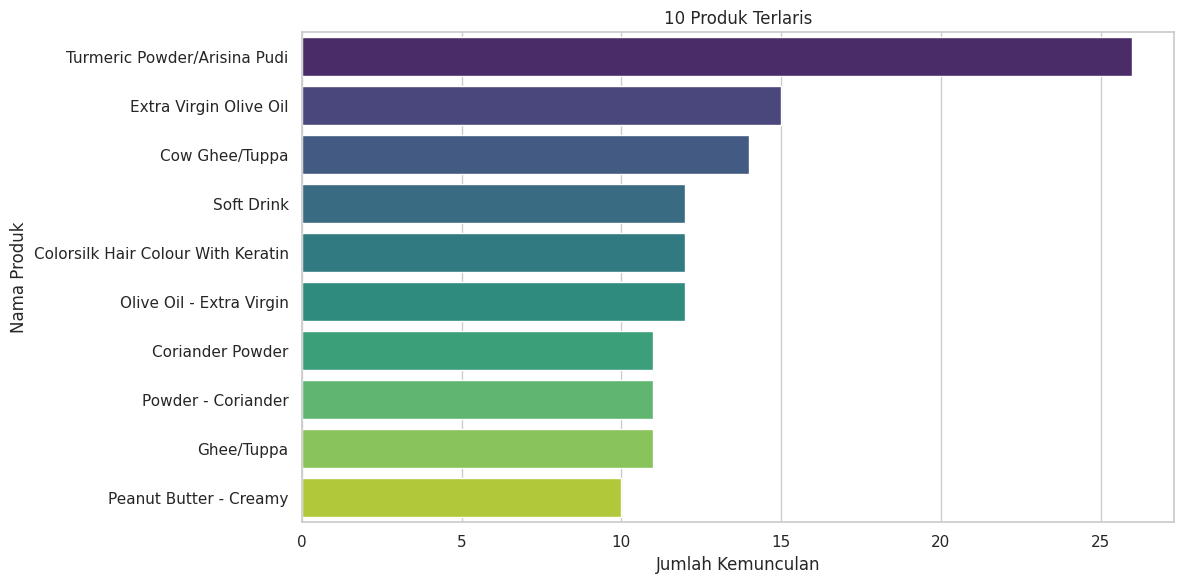

In [10]:
# 10 Produk Terlaris (Paling Banyak Muncul)
top_products = df['product'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('10 Produk Terlaris')
plt.xlabel('Jumlah Kemunculan')
plt.ylabel('Nama Produk')
plt.tight_layout()
plt.show()

Kode ini menghitung frekuensi kemunculan setiap produk menggunakan `value_counts()` dan mengambil 10 teratas sebagai produk terlaris. Grafik batang horizontal dibuat menggunakan `sns.barplot()` untuk memvisualisasikan jumlah kemunculan masing-masing produk. Pengaturan seperti judul, label sumbu, dan tata letak ditambahkan agar grafik informatif dan rapi. Hasilnya menunjukkan 10 produk paling populer dalam dataset, yang dapat dijadikan dasar untuk rekomendasi berbasis popularitas. Hasilnya menunjukkan bahwa produk seperti Turmeric Powder, Extra Virgin Olive Oil, dan Cow Ghee adalah yang paling sering muncul, sehingga bisa dianggap sebagai produk terlaris. Analisis ini membantu memahami tren popularitas dan bisa digunakan sebagai dasar rekomendasi populer.

<ipython-input-11-2796047314>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=least_products.values, y=least_products.index, palette='Reds')


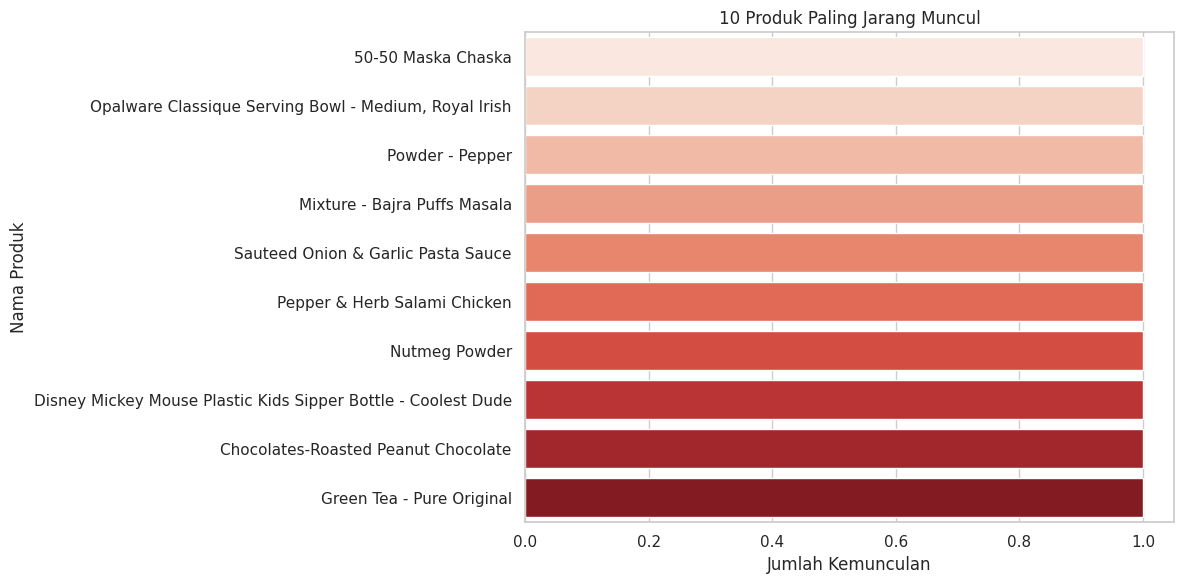

In [11]:
# 10 Produk Paling Jarang Muncul
least_products = df['product'].value_counts().tail(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=least_products.values, y=least_products.index, palette='Reds')
plt.title('10 Produk Paling Jarang Muncul')
plt.xlabel('Jumlah Kemunculan')
plt.ylabel('Nama Produk')
plt.tight_layout()
plt.show()

Kode ini menampilkan 10 produk dengan kemunculan paling sedikit dalam dataset. Produk-produk ini dianggap kurang populer atau jarang dibeli, sehingga informasi ini dapat membantu mengidentifikasi produk niche atau yang memerlukan strategi pemasaran khusus. Visualisasi menggunakan grafik batang memperlihatkan perbandingan jumlah kemunculan tiap produk secara jelas.

<ipython-input-12-454686087>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='Set2')


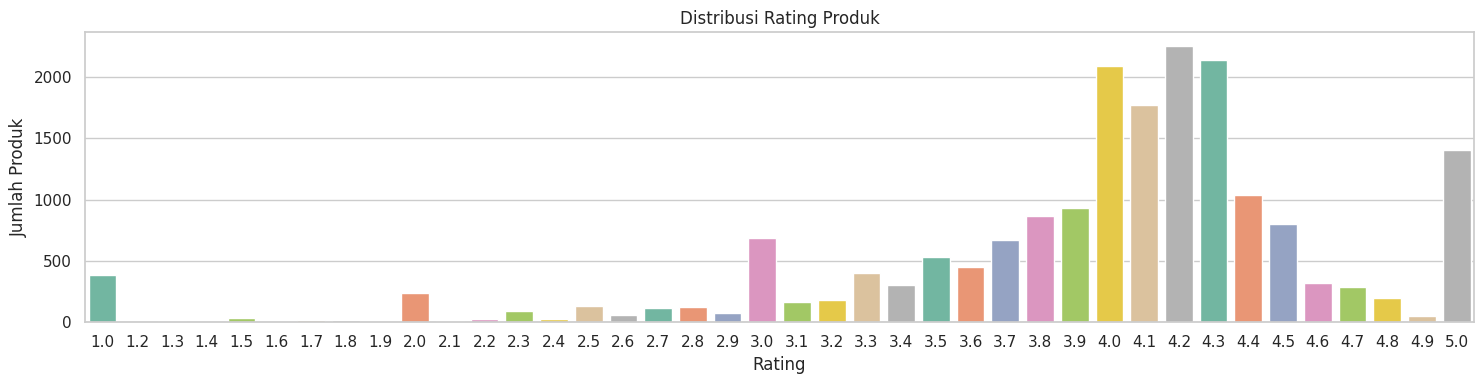

In [12]:
# Distribusi Rating
plt.figure(figsize=(15, 4))
sns.countplot(x='rating', data=df, palette='Set2')
plt.title('Distribusi Rating Produk')
plt.xlabel('Rating')
plt.ylabel('Jumlah Produk')
plt.tight_layout()
plt.show()

Kode ini menampilkan distribusi jumlah produk berdasarkan nilai rating yang diberikan. Dengan menggunakan `countplot`, kita bisa melihat seberapa banyak produk yang mendapatkan masing-masing nilai rating. Visualisasi ini membantu memahami persebaran kualitas produk menurut penilaian pengguna secara keseluruhan. Distribusi rating produk menunjukkan bahwa sebagian besar produk mendapat nilai rating di kisaran 3.0 hingga 4.5, dengan puncak tertinggi pada rating 4.2 (2.251 produk) dan 4.3 (2.140 produk). Rating sangat rendah (di bawah 2.0) dan sangat tinggi (5.0) relatif lebih sedikit, menandakan mayoritas produk mendapatkan penilaian yang cukup baik dan tersebar merata di rentang menengah hingga tinggi.

<ipython-input-13-898739223>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rated_per_cat.values, y=top_rated_per_cat.index, palette='Greens')


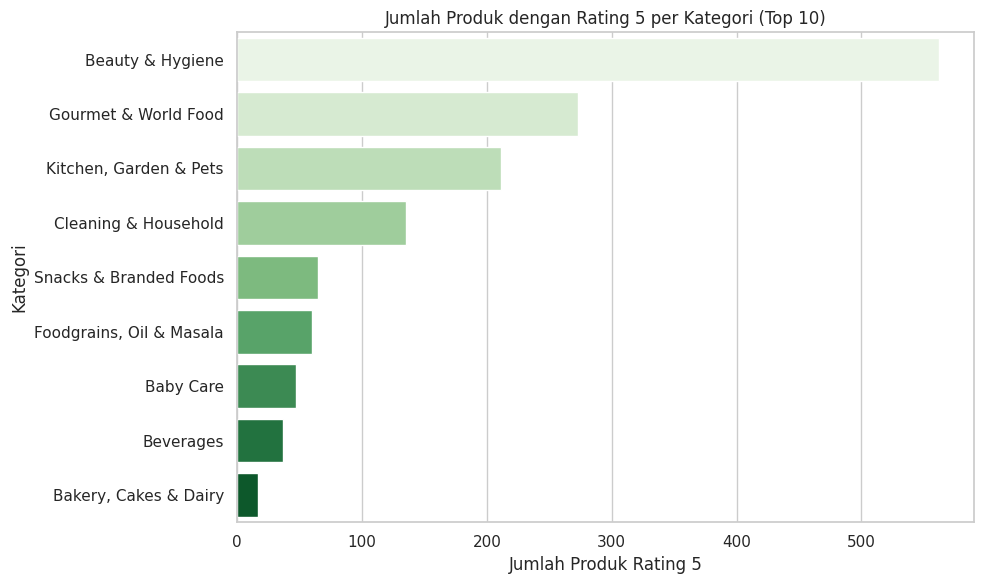

In [13]:
# Produk dengan Rating Tertinggi (5) Berdasarkan Kategori
high_rating_df = df[df['rating'] == 5]
top_rated_per_cat = high_rating_df['category'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_rated_per_cat.values, y=top_rated_per_cat.index, palette='Greens')
plt.title('Jumlah Produk dengan Rating 5 per Kategori (Top 10)')
plt.xlabel('Jumlah Produk Rating 5')
plt.ylabel('Kategori')
plt.tight_layout()
plt.show()

Kode ini menampilkan 10 kategori dengan jumlah produk yang mendapatkan rating tertinggi (nilai 5) terbanyak. Kategori *Beauty & Hygiene* mendominasi dengan 562 produk, diikuti oleh *Gourmet & World Food* dan *Kitchen, Garden & Pets*. Informasi ini membantu mengidentifikasi kategori dengan produk berkualitas unggulan berdasarkan penilaian pengguna.

## Data Preparation

In [14]:
data_clean = df.copy()

Salinan data asli dibuat untuk proses pembersihan dan transformasi tanpa mengubah data mentah.
Langkah ini menjaga data asli tetap utuh agar dapat dibandingkan atau digunakan ulang jika diperlukan.

In [15]:
if 'index' in data_clean.columns:
    data_clean.drop(columns='index', inplace=True)

Kolom index yang tidak relevan dengan analisis dihapus untuk menyederhanakan dataset dan menghindari gangguan saat pemrosesan data selanjutnya.

In [16]:
initial_rows = data_clean.shape[0]
data_clean.drop_duplicates(inplace=True)
final_rows = data_clean.shape[0]
print(f"{initial_rows - final_rows} duplikat dihapus.")

354 duplikat dihapus.


Data diperiksa dan baris duplikat dihapus untuk memastikan setiap produk hanya muncul sekali.
Hal ini penting agar model tidak bias akibat data yang berulang.
Sebanyak 354 baris duplikat berhasil dihapus dari dataset, memastikan data yang digunakan unik dan berkualitas untuk analisis lebih lanjut.

In [17]:
data_clean.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


Menampilkan 5 baris pertama dataset setelah pembersihan data, menghapus duplikat dan menangani nilai kosong.
Dataset kini siap untuk tahap pemrosesan lebih lanjut dengan fitur lengkap dan format yang bersih.

In [18]:
def bersihkan_text(teks):
    if isinstance(teks, list):
        return [t.strip().lower().replace(" ", "") for t in teks]
    elif isinstance(teks, str):
        return teks.strip().lower().replace(" ", "")
    else:
        return ''

def split_multivalue(teks):
    if isinstance(teks, str):
        return re.split(r"&|,|\*|\n", teks)
    return []


for kolom in ['category', 'sub_category', 'type']:
    data_clean[kolom] = data_clean[kolom].apply(split_multivalue).apply(bersihkan_text)

data_clean['brand'] = data_clean['brand'].apply(bersihkan_text)

Dua fungsi dibuat untuk membersihkan dan menyiapkan data kategorikal:

- split_multivalue(teks):
Memisahkan string kategori yang mengandung beberapa nilai (dipisahkan dengan &, ,, *, atau newline) menjadi list. Contoh: "Fruits & Vegetables" → ["Fruits", "Vegetables"].

- bersihkan_text(teks):
Membersihkan teks dari spasi dan mengubahnya menjadi huruf kecil. Jika input berupa list, fungsi ini akan membersihkan setiap elemen dalam list tersebut. Contoh: " Hair Care " → "haircare".

Fungsi-fungsi ini diterapkan pada kolom category, sub_category, dan type agar konsisten dalam format list bersih.
Kolom brand juga dibersihkan untuk menyamakan format meskipun hanya berisi satu nilai.

Langkah ini penting untuk mempersiapkan data sebelum diubah menjadi fitur teks dalam sistem rekomendasi berbasis konten (CBF).

In [19]:
cbf_data = data_clean.copy()

Salinan data bersih dibuat ke dalam variabel cbf_data khusus untuk proses Content-Based Filtering.
Hal ini menjaga data utama tetap utuh saat fitur khusus CBF ditambahkan atau dimodifikasi.

In [20]:
def gabungkan_fitur(row):
    kategori = " ".join(row['category']) if isinstance(row['category'], list) else ''
    sub_kategori = " ".join(row['sub_category']) if isinstance(row['sub_category'], list) else ''
    tipe = " ".join(row['type']) if isinstance(row['type'], list) else ''
    merek = row['brand'] if isinstance(row['brand'], str) else ''

    gabungan = f"{kategori} {sub_kategori} {tipe} {merek}"
    return gabungan.strip()


cbf_data['fitur_gabungan'] = cbf_data.apply(gabungkan_fitur, axis=1)

print("\nhasil penggabungan fitur CBF:")
cbf_data[['product', 'fitur_gabungan']].head()



hasil penggabungan fitur CBF:


,product,fitur_gabungan
0,Garlic Oil - Vegetarian Capsule 500 mg,beauty hygiene haircare hairoil serum srisriay...
1,Water Bottle - Orange,kitchen garden pets storage accessories water ...
2,"Brass Angle Deep - Plain, No.2",cleaning household poojaneeds lamp lampoil trm
3,Cereal Flip Lid Container/Storage Jar - Assort...,cleaning household bins bathroomware laundry s...
4,Creme Soft Soap - For Hands & Body,beauty hygiene bath handwash bathingbars soaps...


Fungsi gabungkan_fitur() dibuat untuk menggabungkan beberapa atribut penting dari produk, yaitu:

- category, sub_category, dan type (dijadikan satu string jika berupa list),

- serta brand.

Gabungan ini disimpan dalam kolom baru fitur_gabungan, yang menjadi representasi teks setiap produk untuk proses Content-Based Filtering.
Contoh hasilnya mencakup kata-kata seperti:
"beauty hygiene haircare hairoil serum srisriayurveda"

Langkah ini penting sebagai input ke TF-IDF Vectorizer dalam tahap selanjutnya.

In [21]:
cbf_unique = cbf_data.drop_duplicates(subset='product', keep='first').reset_index(drop=True)

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(cbf_unique['fitur_gabungan'])

print(f"Ukuran TF-IDF matrix: {tfidf_matrix.shape}")

Ukuran TF-IDF matrix: (23541, 3039)


Untuk membangun model CBF, data duplikat berdasarkan nama produk dihapus agar setiap produk hanya muncul sekali (cbf_unique).
Kolom fitur_gabungan kemudian diproses menggunakan TF-IDF Vectorizer untuk mengubah teks menjadi representasi numerik.

TF-IDF digunakan untuk menangkap pentingnya kata dalam konteks setiap produk, sambil mengabaikan kata-kata umum (stop words).

Output:
Ukuran matriks TF-IDF adalah (23541, 3039), artinya ada 23.541 produk dan 3.039 fitur unik yang terdeteksi dari teks.

## Modeling & Result

In [22]:
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(f"Ukuran cosine similarity matrix: {cosine_sim_matrix.shape}")

Ukuran cosine similarity matrix: (23541, 23541)


Menggunakan cosine similarity, sistem menghitung tingkat kemiripan antar produk berdasarkan representasi TF-IDF-nya.
Setiap produk dibandingkan dengan seluruh produk lainnya untuk menemukan seberapa mirip mereka berdasarkan deskripsi fiturnya.

Output:
Matriks hasil berukuran (23541, 23541), artinya setiap produk memiliki skor kemiripan terhadap 23541 produk lainnya.

Matriks ini akan digunakan untuk menghasilkan rekomendasi produk yang mirip secara konten.

In [26]:
product_indices = pd.Series(cbf_unique.index, index=cbf_unique['product'])

def rekomendasi_produk(nama_produk, cosine_sim=cosine_sim_matrix, df=cbf_unique):
    if nama_produk not in product_indices:
        return f"Produk '{nama_produk}' tidak ditemukan."

    idx = product_indices[nama_produk]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    top_indices = [i[0] for i in sim_scores]

    return df.iloc[top_indices][['product', 'brand']]

produk_acak = cbf_unique['product'].sample(1).values[0]
print(f"Rekomendasi produk mirip dengan: {produk_acak}")
rekomendasi_produk(produk_acak)

Rekomendasi produk mirip dengan: Aloe Vera Bathing Soap - With Vitamin E For Soft, Glowing Skin, Refreshing Fragrance, Combo Pack


,product,brand
21340,Aloe Vera Bathing Soap - With Vitamin E For So...,vivel
3678,"Body Wash - Lavender & Almond Oil, Nourishing ...",vivel
4271,"Body Wash - Lavender & Almond Oil, Shower Creme",vivel
6604,Body Wash - Mint & Cucumber,vivel
10598,"Body Wash - Lavender & Almond Oil, Nourishing ...",vivel
18007,"Body Wash - Mint & Cucumber, Shower Creme",vivel
5858,Neem & Lemon Bathing Soap,inatur
7813,Rose & Geranium Sugar Soap,inatur
11592,Jasmine Butter Soap,inatur
17494,Sandal & Vanilla Soap,inatur


Kode ini mendefinisikan fungsi `rekomendasi_produk()` yang menghasilkan 10 produk paling mirip dengan produk input berdasarkan cosine similarity dari fitur gabungan (hasil TF-IDF).

Langkah-langkah:
- Membuat indeks produk (`product_indices`) untuk mengakses baris data berdasarkan nama produk.
- Dalam fungsi, dicek apakah produk tersedia.
- Mengambil skor kemiripan (cosine similarity) terhadap seluruh produk.
- Mengurutkan skor tersebut dan mengambil 10 produk teratas (kecuali dirinya sendiri).
- Mengembalikan daftar produk dan brand sebagai hasil rekomendasi.

Terakhir, fungsi diuji dengan memilih satu produk secara acak dari dataset.

## Evaluation

In [24]:
# evaluasi Precision@k
def precision_at_k_cbf(df, cosine_sim, k=10):
    hits = 0
    total = 0
    recommended_items = set()

    for idx, row in df.iterrows():
        produk_asli = row['product']
        kategori_asli = set(row['category'])

        produk_idx = product_indices.get(produk_asli, None)
        if produk_idx is None:
            continue

        sim_scores = list(enumerate(cosine_sim[produk_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:k+1]
        top_indices = [i[0] for i in sim_scores]

        rekomendasi = df.iloc[top_indices]

        for _, rec in rekomendasi.iterrows():
            if set(rec['category']) & kategori_asli:
                hits += 1
            recommended_items.add(rec['product'])

        total += k

    precision = hits / total if total else 0
    coverage = len(recommended_items) / df['product'].nunique()
    return precision, coverage


Untuk mengevaluasi performa sistem rekomendasi CBF, digunakan metrik **Precision@k** dan **Coverage**.

- **Precision@k**: Mengukur proporsi item rekomendasi yang termasuk dalam kategori yang sama dengan produk asli. Ini mencerminkan relevansi rekomendasi.
- **Coverage**: Mengukur sejauh mana sistem merekomendasikan beragam produk dari keseluruhan dataset.

Fungsi `precision_at_k_cbf()` akan menghitung kedua metrik ini berdasarkan kesamaan kategori antara produk asli dan hasil rekomendasinya.

Fungsi ini mengevaluasi top-k rekomendasi dari setiap produk berdasarkan cosine similarity.

hits bertambah jika kategori produk rekomendasi memiliki irisan dengan kategori produk asli.

recommended_items digunakan untuk menghitung seberapa luas cakupan rekomendasi yang diberikan (coverage).

In [25]:
  precision, coverage = precision_at_k_cbf(cbf_unique, cosine_sim_matrix, k=10)

  print(f"Precision@10: {precision:.4f}")
  print(f"Coverage: {coverage:.4f}")

Precision@10: 0.9988
Coverage: 0.6901


Evaluasi sistem rekomendasi CBF dilakukan menggunakan metrik **Precision@10** dan **Coverage**.

- **Precision@10** sebesar **0.9988** menunjukkan bahwa hampir semua produk yang direkomendasikan berada dalam kategori yang sama dengan produk input, yang mengindikasikan bahwa rekomendasi sangat relevan.
- **Coverage** sebesar **0.6901** berarti sistem berhasil merekomendasikan sekitar 69% dari total produk unik yang tersedia, mencerminkan jangkauan rekomendasi yang cukup luas.